# Project 4 'Computer says no'

The goal is to forecast the probability of client's default on a loan based on the client's attributes and by applying the Logistic Regression.

## Notebook contents

1. [Dataset description](#desc)
2. [EDA](#eda)
    * [Numeric parameters](#num)
    * [Binary parameters](#bin)
    * [Categorical parameters](#cat)
3. [Naive model train](#naive)
4. [Adding new attributes](#add)
5. [Hyperparameters search](#hyper)
6. [Submission](#sub)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

## <a name="desc">Dataset description</a>

The dataset contains the records on clients with the following attributes:
* client_id - id of a client
* education - client's degree
* sex - sex of a client (M/F)
* age - age of a client
* car - a flag (Y/N) identifing if a client has a car
* car_type - a flag (Y/N) specifing if a client has a car of a foreign brand (usually more expensive)
* decline_app_cnt - number of declined application in the past
* good_work - a flag (0/1) specifing if a client has a 'good' job (the criteria of what is 'good' is unknown)
* bki_request_cnt - number of prior requests to BKI (centralized credit history database), can be a signal of multiple or frequent applications
* home_address - category of a home address (criteria unknown)
* work_address - category of a work address (criteria unknown)
* income - client's income
* foreign_passport - a flag (Y/N) identifing if a client has a foreign passport
* sna - a category specifing if a client is linked to other bank's clients
* first_time - a category specifing how long age client's information was updated
* score_bki - scoring based on BKI
* region_rating - rating of a client's region
* app_date - application date
* default - a flag (0/1) identifing if a client had a default. The attribute is provided only for the train dataset but not for the test.


Let's upload both train and test datasets and unite them in order to ensure the same pre-processing. Flag 1 is to be assigned to the train dataset and 0 - to the test one.

Test dataset has no 'default' column, so we'll assign it to nan.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
test['default'] = np.nan

train['sample'] = 1  
test['sample'] = 0

data = test.append(train, sort=False).reset_index(drop=True)

In [4]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,NaN,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,NaN,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,NaN,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,NaN,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,NaN,0


## <a name="eda">EDA</a>

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Let's delete 'client_id' because this attribute doesn't influence whether a client will default.

Missed values in 'education' to be filled with the most frequent value ('SCH').

In [6]:
data.drop('client_id', axis=1, inplace=True)

In [7]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [8]:
data['education'] = data['education'].fillna(data.education.mode()[0])

Let's split all the feautures into binary, categorical and numeric in order to process them separately.

In [9]:
#binary parameters
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

#categorical parameters
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating', 'app_date']

#numeric parameters
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki']

### <a name="num">Numeric parameters</a>

In [10]:
def numeric(column_name):
    # Introduce a function for analysis of numeric data
    fig, (g1, g2, g3) = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Histogram and boxplots for {0} '.format(column_name), fontsize=18)
    
    g1.hist(data[data['default'] == 0][column_name]) # attribute hist separately for default and non-default clients
    g1.hist(data[data['default'] == 1][column_name])
    g1.set_xlabel(column_name + ' values')
    g1.set_ylabel('clients cnt')
    
    g2.boxplot(data[column_name]) # boxplot for all values of an attribute
    g2.set_ylabel(column_name)
    
    g3 = sns.boxplot(x="default", y=column_name, data=data) # 2 separate boxplots for default and non-default clients
    
    plt.show()

    summary = data[column_name].describe() # summary statistics and outliers
    print(summary)
    
    q1 = summary['25%']
    q3 = summary['75%']
    iqr = q3 - q1
    print('Interquartile range is {}; non-outlier are from {} to {}'.format(iqr, q1 - iqr*1.5, q3 + iqr*1.5))
    
    outliers = data[(data[column_name] > q3 + iqr*1.5) | (data[column_name] < q1 - iqr*1.5)]
    print('{} outlier(s)'.format(len(outliers)))

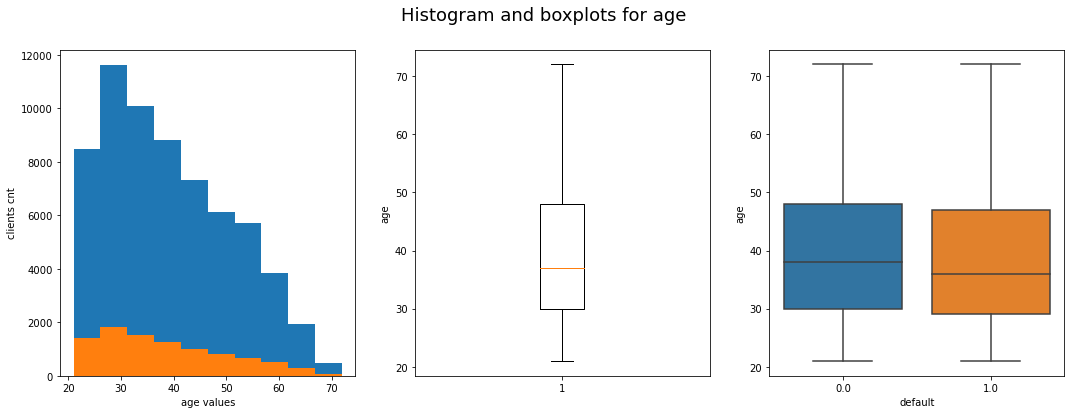

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64
Interquartile range is 18.0; non-outlier are from 3.0 to 75.0
0 outlier(s)


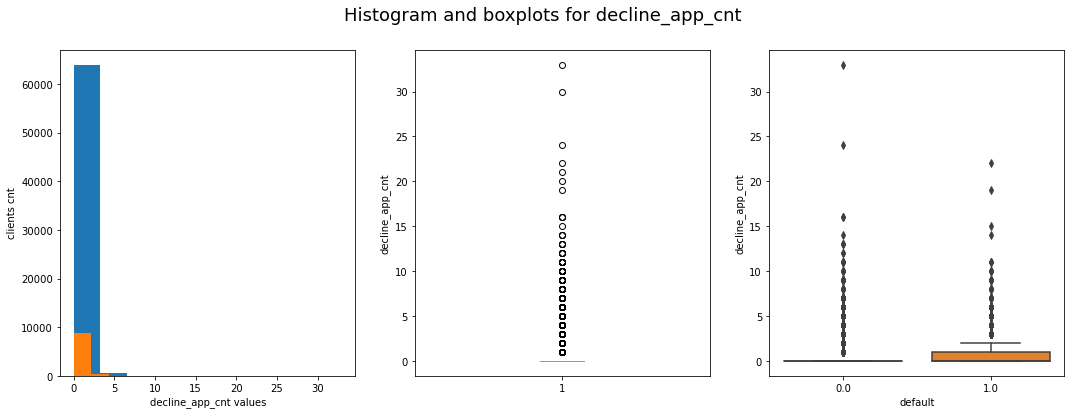

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64
Interquartile range is 0.0; non-outlier are from 0.0 to 0.0
18677 outlier(s)


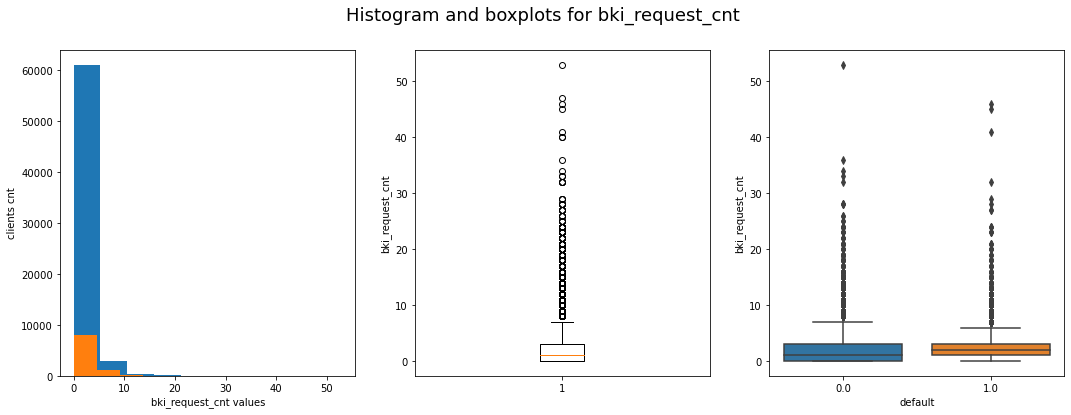

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64
Interquartile range is 3.0; non-outlier are from -4.5 to 7.5
2636 outlier(s)


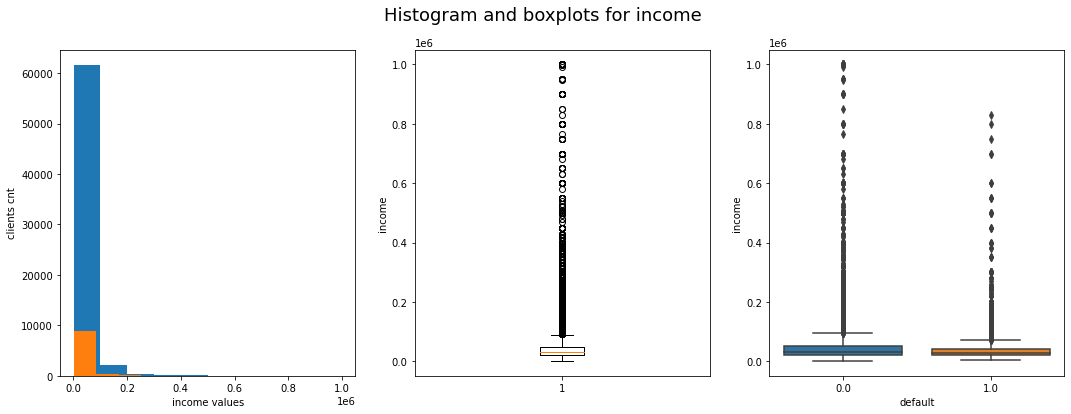

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64
Interquartile range is 28000.0; non-outlier are from -22000.0 to 90000.0
7000 outlier(s)


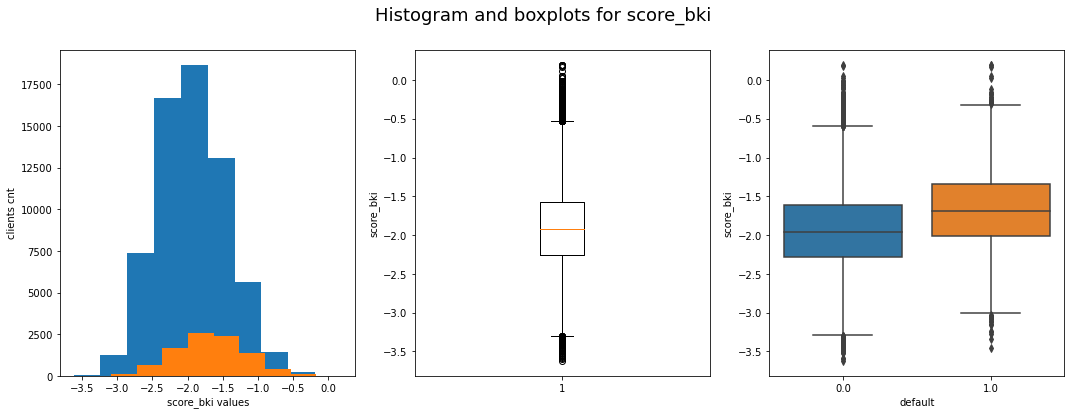

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64
Interquartile range is 0.6925455175000004; non-outlier are from -3.299251946250001 to -0.5290698762499992
518 outlier(s)


In [11]:
for i in num_cols: # apply the function to all numeric attributes
    numeric(i)

All numeric attributes, except 'age', have a lot of outliers (according to the IQR formula). Moreover, all attributes, except 'score_bki', have non-normal distribution. To figth both these issues, let's try to log all of them, except 'score_bki' and 'decline_app_cnt'.

Log of 'decline_app_cnt' wouldn't reduce the number of outliers. Instead of that let's transform this attribute to the categorical one, where:

0 - a client with no declined applications;

1 - a client with 1-2 declined applications;

2 - a client with 3 declined applications or more.

In [12]:
def decline_app_transform(x):
    if x == 0:
        return 0
    elif x < 3:
        return 1
    else:
        return 2

    
data['decline_app_cnt'] = data['decline_app_cnt'].apply(decline_app_transform) # transform to categorical
cat_cols.append('decline_app_cnt') # add this attribute to the list of categorical columns
num_cols.remove('decline_app_cnt') # remove from the list of numeric

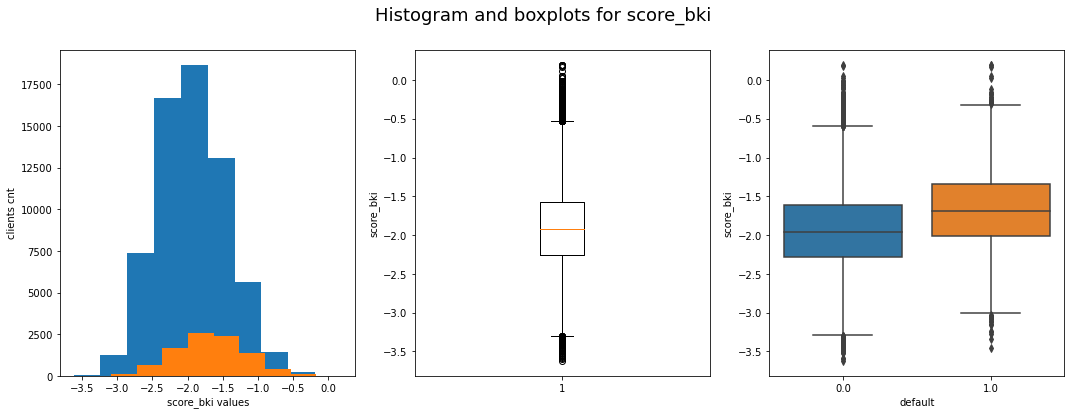

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64
Interquartile range is 0.6925455175000004; non-outlier are from -3.299251946250001 to -0.5290698762499992
518 outlier(s)


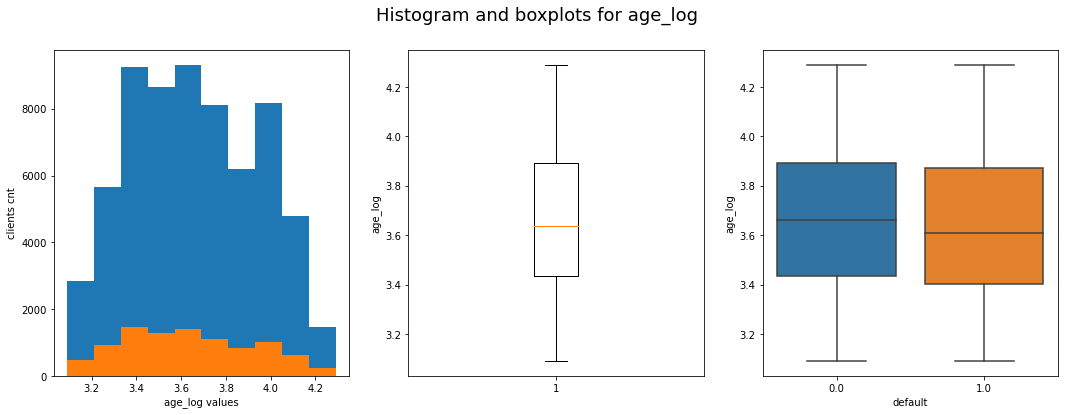

count    110148.000000
mean          3.654546
std           0.285054
min           3.091042
25%           3.433987
50%           3.637586
75%           3.891820
max           4.290459
Name: age_log, dtype: float64
Interquartile range is 0.4578330936254802; non-outlier are from 2.7472375640469258 to 4.5785699385488465
0 outlier(s)


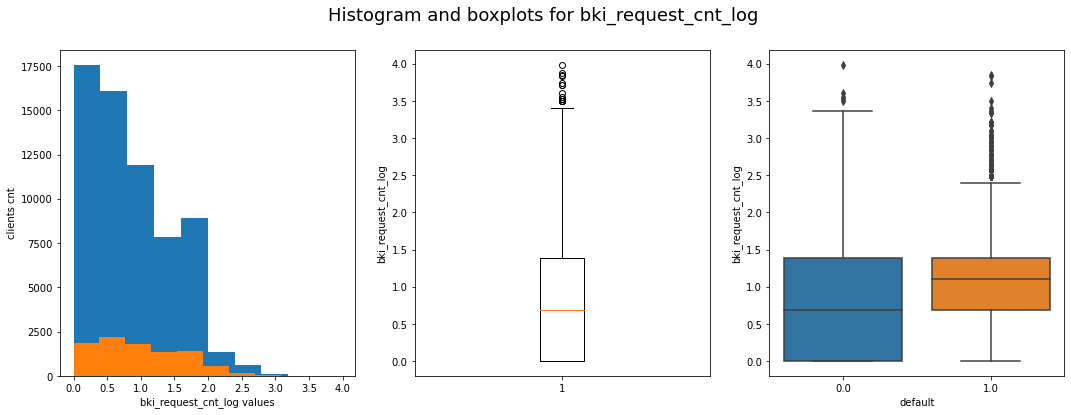

count    110148.000000
mean          0.878752
std           0.658667
min           0.000000
25%           0.000000
50%           0.693147
75%           1.386294
max           3.988984
Name: bki_request_cnt_log, dtype: float64
Interquartile range is 1.3862943611198906; non-outlier are from -2.0794415416798357 to 3.465735902799726
15 outlier(s)


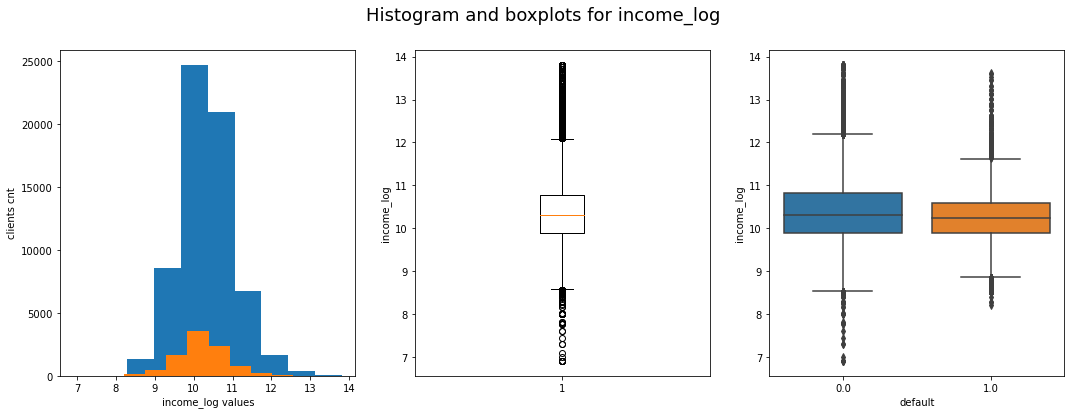

count    110148.000000
mean         10.345792
std           0.696636
min           6.908755
25%           9.903538
50%          10.308986
75%          10.778977
max          13.815512
Name: income_log, dtype: float64
Interquartile range is 0.8754395717201806; non-outlier are from 8.590378193705899 to 12.092136480586621
2609 outlier(s)


In [13]:
for i in ['age', 'bki_request_cnt', 'income']: # log of three attributes in order to make their distribution more normal
    data[i + '_log'] = np.log(data[i] + 1)
    num_cols.append(i + '_log')
    num_cols.remove(i)
    
for i in num_cols: #apply the analysis function to the new list of numeric attributes (after log)
    numeric(i)

We managed to reduce the number of outliers and the distribution looks more normal now. However, there are still 518 outliers for the 'score_bki', 15 - for 'bki_request_cnt' and 2609 - for 'income'. The judgement on outliers was made based on the standard IQR formula, however this data may be important for our model. Moreover, we don't want to delete rows as it will change the order of client ids, which is important to preserve for the Kaggle submission.

Let's now scale the numeric attributes by applying RobustScaler():

In [14]:
data[num_cols] = RobustScaler().fit_transform(data[num_cols])

The heatmap of the numeric attributes shows no significant correlations.

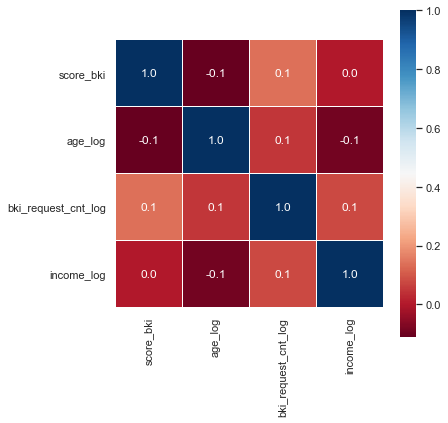

In [15]:
sns.set(font_scale=1)
plt.subplots(figsize=(6, 6))
sns.heatmap(data[num_cols].corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Let's estimate attributes importance using F-values. The 'score_bki' stands out.

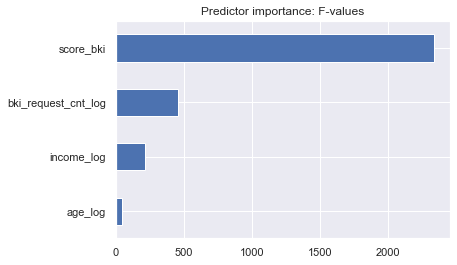

In [16]:
imp_num = pd.Series(f_classif(data[data['sample'] == 1][num_cols],
                              data[data['sample'] == 1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', title='Predictor importance: F-values')

In [17]:
data[num_cols].head()

,score_bki,age_log,bki_request_cnt_log,income_log
0,-0.506914,-0.516321,0.500000,0.583492
1,0.600428,0.112035,0.292481,-2.046507
2,0.331363,0.642678,0.000000,0.000000
3,-0.654628,0.885618,0.000000,-0.648770
4,-0.818256,0.056736,-0.500000,1.583512


### <a name="bin">Binary parameters</a>

In [18]:
def binary(column_name):
    # Introduce a function for analysis of binary data
    data[column_name] = data[column_name].apply(lambda x: str(x)) # convert to string if it's not
    ax = sns.histplot(data, x=column_name, hue='default', stat='count', multiple='fill')
    plt.title(data[column_name].name + ' distribution')
    ax.set(ylabel='Proportion')
    plt.show()

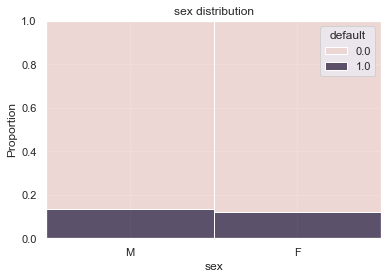

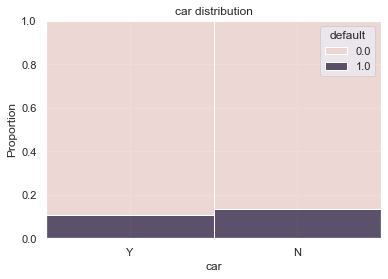

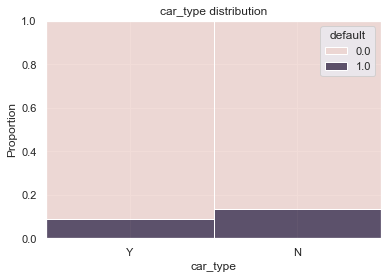

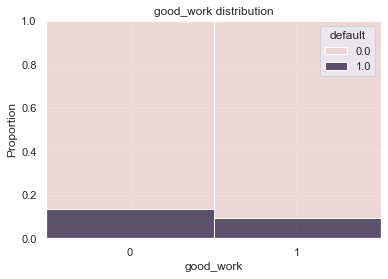

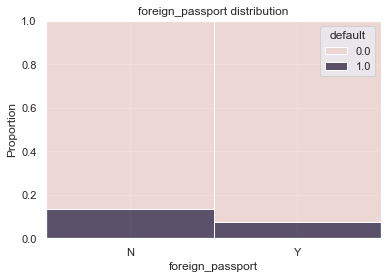

In [19]:
for i in bin_cols: # apply the binary analysis function to all binary columns
    binary(i)

We can conclude that better borrowers:
* females are slightly better borrowers;
* have a car and preferrably of a foreign brand;
* have good work;
* have a foreign passport.

These outcomes make sense as owning a car, having a good job and having a foreign passport (possibility to travel abroad) can all be associated with better financial situation of a customer.

Now let's transform the binary attributes to '0' / '1' by LabelEncoder:

In [20]:
label_encoder = LabelEncoder()

for i in bin_cols:
    data[i] = label_encoder.fit_transform(data[i])

In [21]:
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,1,0,1
3,1,0,0,0,0
4,0,0,0,0,0


### <a name="cat">Categorical parameters</a>

In [22]:
def categorical(column_name):
    # Introduce a function for analysis of categorical data
    print(f'{column_name:=^20}')
    
    # Existing values and their counts
    values_series = data[column_name].value_counts()
    
    # Find the most frequent values
    print('The most frequent value is {}; {:.0f}% of total'.format(values_series.index[0],
                                                                   (values_series.values[0] / values_series.sum()) * 100))
    
    print('The most frequent if not default is {}'.format(data[data['default'] == 0][column_name].value_counts().index[0]))
    print('The most frequent if default is {}'.format(data[data['default'] == 1][column_name].value_counts().index[0]))
    
    data[column_name] = data[column_name].apply(lambda x: str(x)) # convert to string if it's not
    # hist with default shown separately
    sns.histplot(data, x=column_name, hue='default', stat='count', multiple='fill').set(ylabel='Proportion')
    plt.show()
    
    print(values_series[:7])
    print()

Let's transform application date from string to datetime format. We see that the dataset covers application submitted from January to April.

In [23]:
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')

data['app_month'] = data['app_date'].dt.month
data['app_month'].value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_month, dtype: int64

The year of all applications is the same (2014) so it won't be a meaningful attribute for us, so let's drop the 'app_year' attribute and include 'app_month' to the list of categorical attributes.

In [24]:
data['app_year'] = data['app_date'].dt.year
data['app_year'].value_counts()

2014    110148
Name: app_year, dtype: int64

In [25]:
data = data.drop('app_year', axis=1)
cat_cols.append('app_month')
cat_cols.remove('app_date')

=====education======
The most frequent value is SCH; 53% of total
The most frequent if not default is SCH
The most frequent if default is SCH


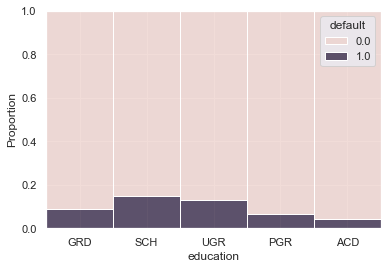

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

====home_address====
The most frequent value is 2; 54% of total
The most frequent if not default is 2
The most frequent if default is 2


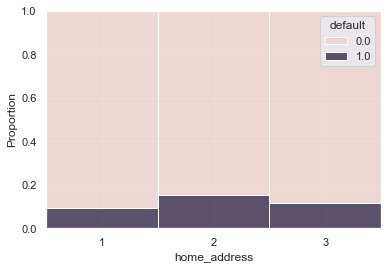

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

====work_address====
The most frequent value is 3; 61% of total
The most frequent if not default is 3
The most frequent if default is 3


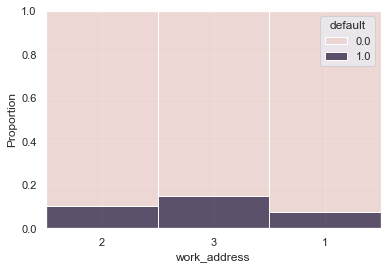

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

========sna=========
The most frequent value is 1; 64% of total
The most frequent if not default is 1
The most frequent if default is 1


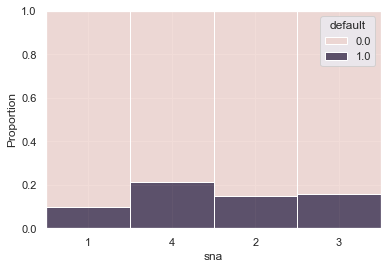

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

=====first_time=====
The most frequent value is 3; 42% of total
The most frequent if not default is 3
The most frequent if default is 3


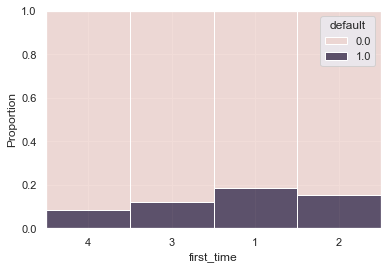

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

===region_rating====
The most frequent value is 50; 37% of total
The most frequent if not default is 50
The most frequent if default is 50


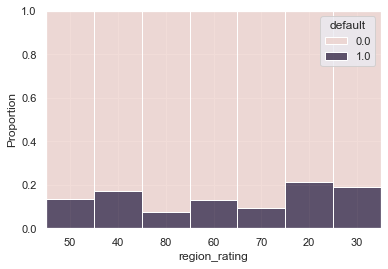

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

==decline_app_cnt===
The most frequent value is 0; 83% of total
The most frequent if not default is 0
The most frequent if default is 0


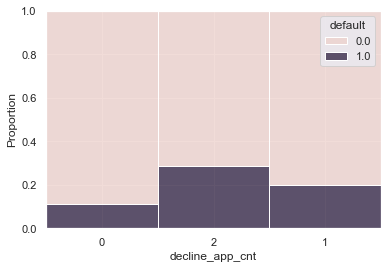

0    91471
1    16122
2     2555
Name: decline_app_cnt, dtype: int64

=====app_month======
The most frequent value is 3; 29% of total
The most frequent if not default is 3
The most frequent if default is 3


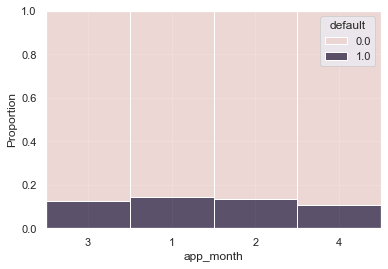

3    31597
2    27097
4    26266
1    25188
Name: app_month, dtype: int64



In [26]:
for i in cat_cols: # apply categorical analysis function to all categorical attributes
    categorical(i)

The analysis shows that the most frequent value is usually the most frequent both for default and non-default clients. However, we can see that better borrower:
* have higher academic degrees;
* have home address category 1;
* have work address category 1;
* have sna category 1;
* have first_time category 4;
* have 70-80 region rating;
* have no declined applications in the past;
* applied in April (however, this may be linked to the fact that their loans have less time exposure to the risk, i.e. they may default latter).

Let's transform 'education' to numeric label in order to be able to assess its impact on the resulting 'default'.

In [27]:
enc = LabelEncoder()
enc.fit(data['education'])
data['education'] = enc.transform(data['education'])

Assessment of the importance of categorical and binary features demonstrates the importance of 'sna'.

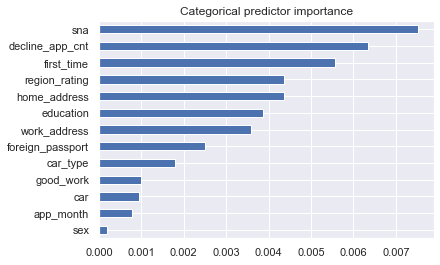

In [28]:
imp_cat = pd.Series(mutual_info_classif(data[data['sample'] == 1][bin_cols + cat_cols], data[data['sample'] == 1]['default'],
                                        discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Categorical predictor importance')

Let's transform categorical parameters to dummies:

In [29]:
data = pd.get_dummies(data, prefix=cat_cols, columns=cat_cols)

In [30]:
data.drop(num_cols + bin_cols + ['default', 'sample', 'age', 'bki_request_cnt', 'income', 'app_date'], axis=1).head()

,education_0,education_1,education_2,education_3,education_4,home_address_1,home_address_2,home_address_3,work_address_1,work_address_2,...,region_rating_60,region_rating_70,region_rating_80,decline_app_cnt_0,decline_app_cnt_1,decline_app_cnt_2,app_month_1,app_month_2,app_month_3,app_month_4
0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0
2,0,0,0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,0,0,0,1,0,0


## <a name="naive">Naive model train</a>

First, let's train the Logistic Regression model on the existing parameters and default hyperparameters in order to have something for a benchmark.

Let's start with defining functions that will help up evaluate our models by using accuracy, precision, recall, F1-score and ROC-AUC metrics and a ROC curve.

In [31]:
# Таблица метрик для сравнения результатов каждой модели -- заимствовано у Melnik Natalia
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']
summary = pd.DataFrame(index=metrics)


def summary_metrics(summary, col, y_valid, y_pred, y_probs):
    values = [accuracy_score(y_valid, y_pred), precision_score(y_valid, y_pred), recall_score(y_valid, y_pred),
              f1_score(y_valid, y_pred), roc_auc_score(y_valid, y_probs)]
    summary[col] = values
    return summary


def calc_and_plot_roc(y_true, y_pred_proba):
    # ROC curve calculation and square under the AUC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

Let's split out dataset back to the train and test and remove all columns which we won't use for prediction (e.g., the columns which were logarithmed earlier, application date, 'sample' flag and 'default' column for test as it has no values.)

In [32]:
train_data = data[data['sample'] == 1].drop(['sample', 'age', 'bki_request_cnt', 'income', 'app_date'], axis=1)
test_data = data[data['sample'] == 0].drop(['sample', 'default', 'age', 'bki_request_cnt',
                                            'income', 'app_date'], axis=1)

In [33]:
# split per attributes and a target value
X = train_data.drop('default', axis=1).values
y = train_data['default'].values

In [34]:
# split per train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=10, stratify=y)

Train the model applying class_weight='balanced' which should compensate for the fact that our target values (default / non-default) are not balanced: there are many more diligent clients than defaults.

In [35]:
model_0 = LogisticRegression(max_iter=1000, random_state=10, class_weight='balanced')
model_0.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=10)

Predict probabilities of default and client category (0/1) for the validation set (X_valid).

In [36]:
probs = model_0.predict_proba(X_valid)
y_probs = probs[:, 1]

y_pred = model_0.predict(X_valid)

Model evaluation by the summary of metrics.

In [37]:
summary_metrics(summary, 'Naive model', y_valid, y_pred, y_probs)

,Naive model
accuracy,0.676061
precision,0.229931
recall,0.660028
f1_score,0.341051
ROC_AUC,0.731785


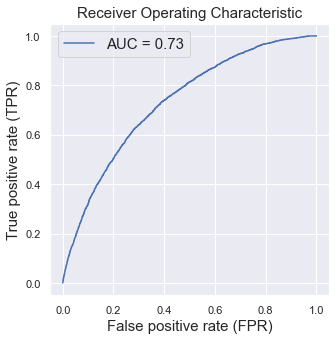

In [38]:
calc_and_plot_roc(y_valid, y_probs)

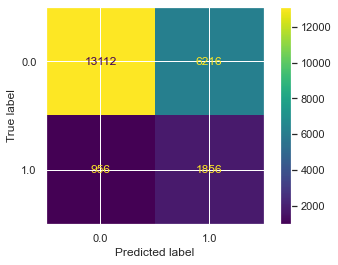

In [39]:
plot_confusion_matrix(model_0, X_valid, y_valid)

Model's accuracy is 0.68, however the model can be improved:
* we correctly predicted around two thirds of all defaulted clients, however almost 1000 defaults were not revealed by the model;
* we refused almost a third of clients who didn't default, thus potential lost 1/3 of profits.

## <a name="add">Adding new attributes</a>

Let's see what other attributes we can generate based on our dataset:
* Day of the week when an application was submitted;
* Combination of good work and certain work address category;
* Combination of home and work address categories (both home and work addresses were quite high at the importance predictor).

In [40]:
# day of the week
data['day_of_week'] = data['app_date'].dt.weekday

for i in range(1, 4): # combination of certain work address and good work
    data['goodwork_workaddress_'+str(i)] = data['work_address_'+str(i)] * data['good_work']

for i in range(1, 4): # combinations of certain home and work addresses
    for j in range(1, 4):
        data['home_work_'+str(i)+str(j)] = data['home_address_'+str(i)] * data['work_address_'+str(j)]

In [41]:
all_cols = [] # all attributes to feed the model
for i in data.columns:
    if not(i in ['app_date', 'default', 'sample', 'age', 'bki_request_cnt', 'income']):
        all_cols.append(i)

Correlation heatmap now shows some high correlations, not only among our newly generated attributes but also among those existing in the naive model (e.g., home_address_1 vs home_address_2). This is likely to be a result of the fact that our attributes are already converted to dummies, so let's try to train the model anyway without dropping any attributes.

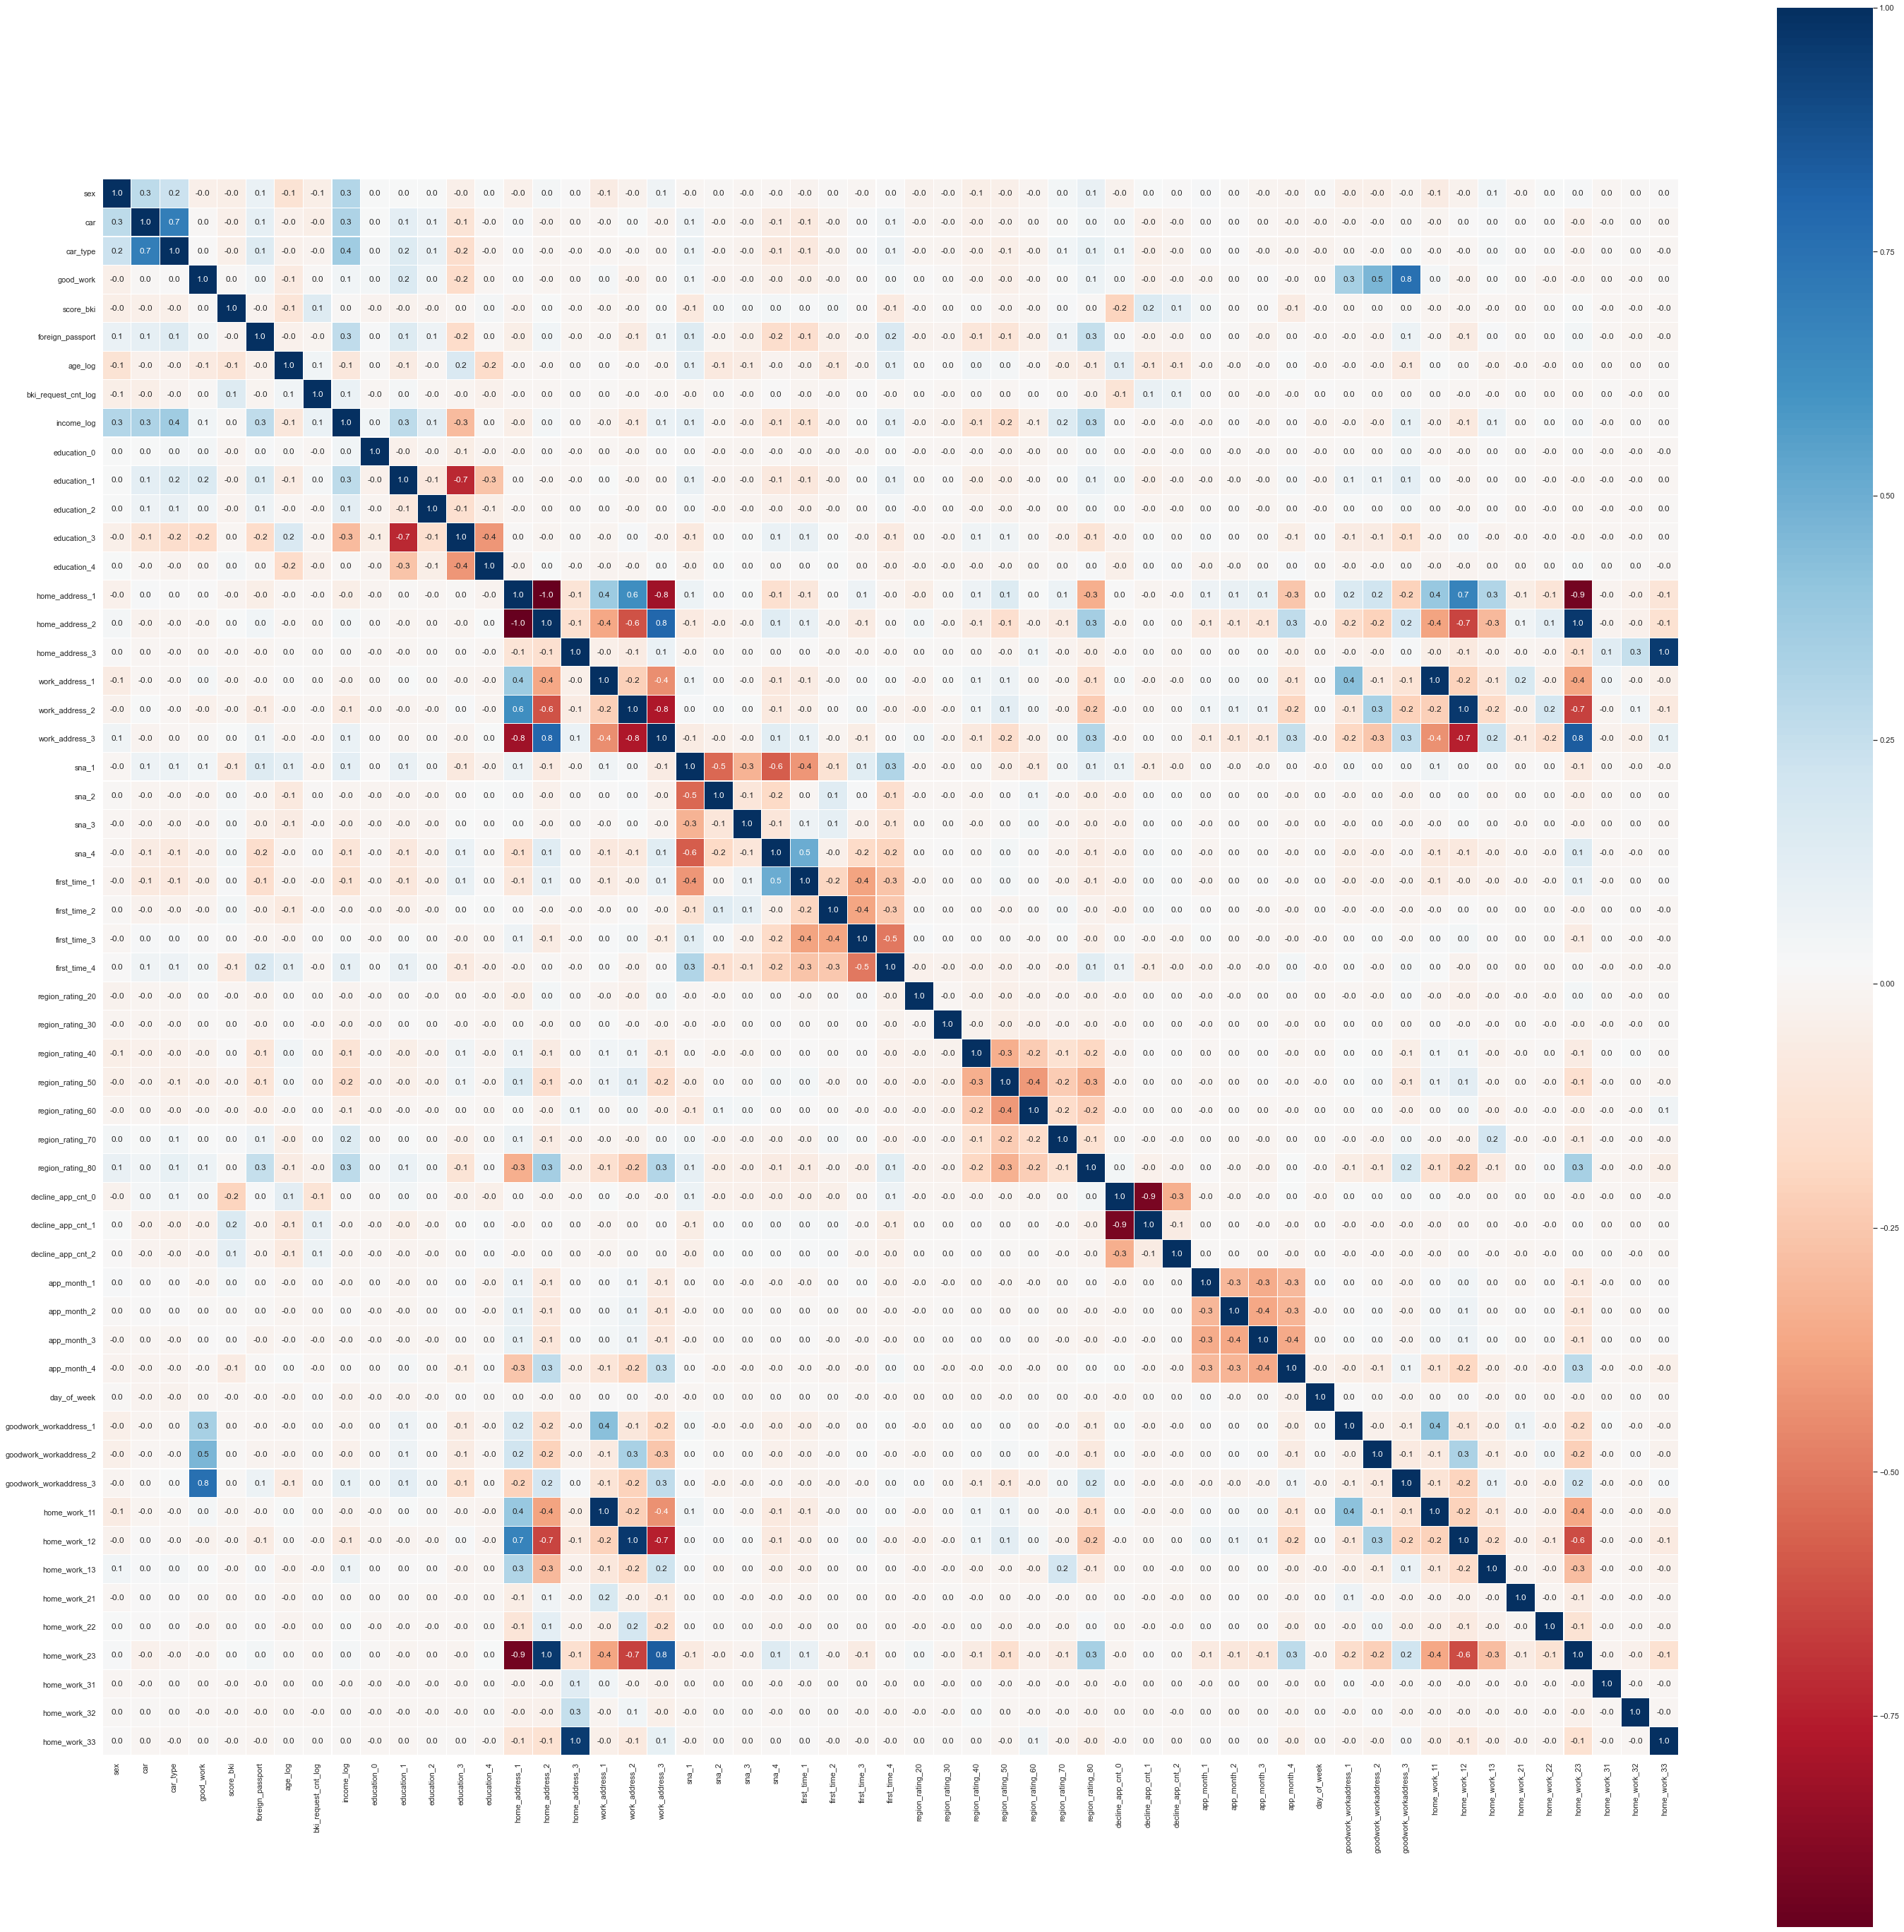

In [42]:
sns.set(font_scale=1)
plt.subplots(figsize=(50, 50))
sns.heatmap(data[all_cols].corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

In [43]:
# split to test and train including newly generated columns
train_data = data[data['sample'] == 1][all_cols + ['default']]
test_data = data[data['sample'] == 0][all_cols]

# split per attributes and target values
X = train_data.drop('default', axis=1).values
y = train_data['default'].values

# split per train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=10, stratify=y)

model_1 = LogisticRegression(max_iter=1000, random_state=10, class_weight='balanced')
model_1.fit(X_train, y_train)

# predict probabilities and client categories
probs = model_1.predict_proba(X_valid)
y_probs = probs[:, 1]

y_pred = model_1.predict(X_valid)

# print summary of metrics
summary_metrics(summary, 'model 1', y_valid, y_pred, y_probs)

,Naive model,model 1
accuracy,0.676061,0.676829
precision,0.229931,0.230617
recall,0.660028,0.661095
f1_score,0.341051,0.341948
ROC_AUC,0.731785,0.732397


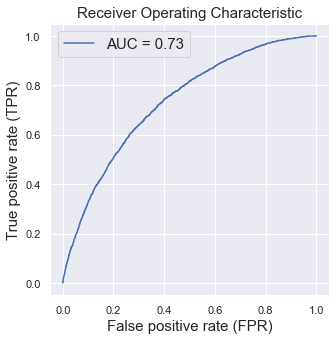

In [44]:
calc_and_plot_roc(y_valid, y_probs)

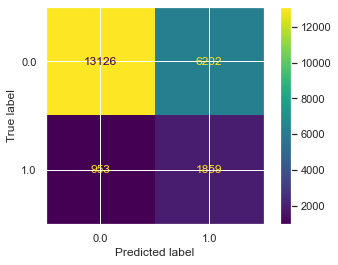

In [45]:
plot_confusion_matrix(model_1, X_valid, y_valid)

We have very slight improvement over the bunch of metrics but still worth to keep the new attributes.

## <a name="hyper">Hyperparameters search</a>

Let's try to optimize the model by selecting hyper parameters (penalty and C) by using GridSearchCV.

In [46]:
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

best_penalty = best_model.best_estimator_.get_params()['penalty']
best_C = best_model.best_estimator_.get_params()['C']

print('Best penalty:', best_penalty)
print('Best C:', best_C)

Best penalty: l2
Best C: 21.544346900318832


In [47]:
# train the model with the best penalty and C
model_2 = LogisticRegression(penalty=best_penalty, C=best_C, max_iter=1000, random_state=10, class_weight='balanced')
model_2.fit(X_train, y_train)

probs = model_2.predict_proba(X_valid)
y_probs = probs[:, 1]
y_pred = model_2.predict(X_valid)

summary_metrics(summary, 'model 2', y_valid, y_pred, y_probs)

,Naive model,model 1,model 2
accuracy,0.676061,0.676829,0.676920
precision,0.229931,0.230617,0.230674
recall,0.660028,0.661095,0.661095
f1_score,0.341051,0.341948,0.342011
ROC_AUC,0.731785,0.732397,0.732378


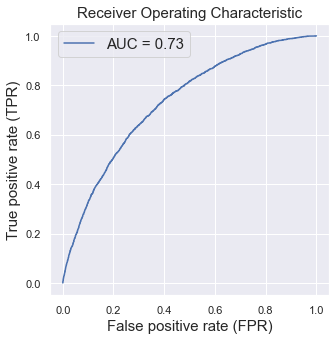

In [48]:
calc_and_plot_roc(y_valid, y_probs)

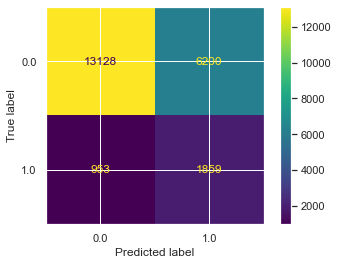

In [49]:
plot_confusion_matrix(model_2, X_valid, y_valid)

Again, we have very slight improvement of the metrics.

## <a name="sub">Submission</a>

Let's create the submission for Kaggle by predicting the probabilities of default for the clients in the test dataset and assigning them to the 'client_id'.

In [50]:
X_test = test_data
y_pred_prob = model_2.predict_proba(X_test)[:, 1]
submit = pd.DataFrame(test['client_id'])
submit['default'] = y_pred_prob
submit.to_csv('submission.csv', index=False)
submit

,client_id,default
0,74835,0.220177
1,17527,0.741689
2,75683,0.324784
3,26883,0.393331
4,28862,0.136639
...,...,...
36344,83775,0.818536
36345,106254,0.106952
36346,81852,0.795883
36347,1971,0.639176
